# Proyecto Multivariados

## Datos

#### Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522


This particular dataset has been used in the following publications:

*Miller, Kai J., et al. "Decoupling the cortical power spectrum reveals real-time representation of individual finger movements in humans." Journal of Neuroscience 29.10 (2009): 3132-3137.*

*Miller, Kai J., et al. "Human motor cortical activity is selectively phase-entrained on underlying rhythms." (2012): e1002655.*

`alldat` contain 3 sessions from 3 subjects, and was used in this paper:

https://pubmed.ncbi.nlm.nih.gov/17873429/

From the dataset readme:

*finger movement task, subjects were cued with a word displayed on a bedside monitor indicating which finger to move during 2- second movement trials. The subject performed self-paced movements in response to each of these cues, and they typically moved each finger 2–5 times during each trial, but some trials included many more movements.
"stim" (time x 1):
0 – Inter-stimulus interval
1 – thumb
2 – index finger
3 – middle finger
4 – ring finger
5 – little finger*

The motion of the fingers was captured with a dataglove, which was sampled at the same rate (1000Hz) as the voltage data. From the dataset readme:

*finger flexions, measured from the hand contralateral to grid placement. Note that they are in the raw form input. They are in 40ms blocks, and have non-zero offset. The 5 columns correspond to the digits thumb-index-middle-ring-little in order. Finger positions were recorded using a 5 degree-of-freedom dataglove sensor (5 dt, Irvine, CA).*

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size (please convert back to float32 for analysis).

Variables are:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['locs`]: three-dimensional coordinates of the electrodes (n_channels by 3)
* `dat['dg']`: digit flexions (time x number of fingers). This was preprocessed from the original data to remove a moving baseline.
* `dat['srate']`: sampling rate (always 1000)
* `dat['t_on']`: time of cue onset
* `dat['t_off']`: time of cue offset (usually 2000ms after `t_on`)
* `dat['stim_id']`: cue identity (which finger to flex)
* `dat['stimtext']`: cue text on the screen

In [11]:
# @title Data retrieval
import os, requests

fname = 'fingerflex.npz'
url = "https://osf.io/5m47z/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [12]:
from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [13]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']
# un arreglo de largo 1 tienen un arreglo de largo 3 con diccionarios 
# así nos quedamos con el arreglo de largo 3 con diccionarios
alldat = alldat[0]
dat = alldat[0]

print(f"Tenemos {alldat.size} sujetos")

Tenemos 3 sujetos


### Electrodos

In [14]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

c:\Users\mateo\anaconda3\envs\itam\Lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


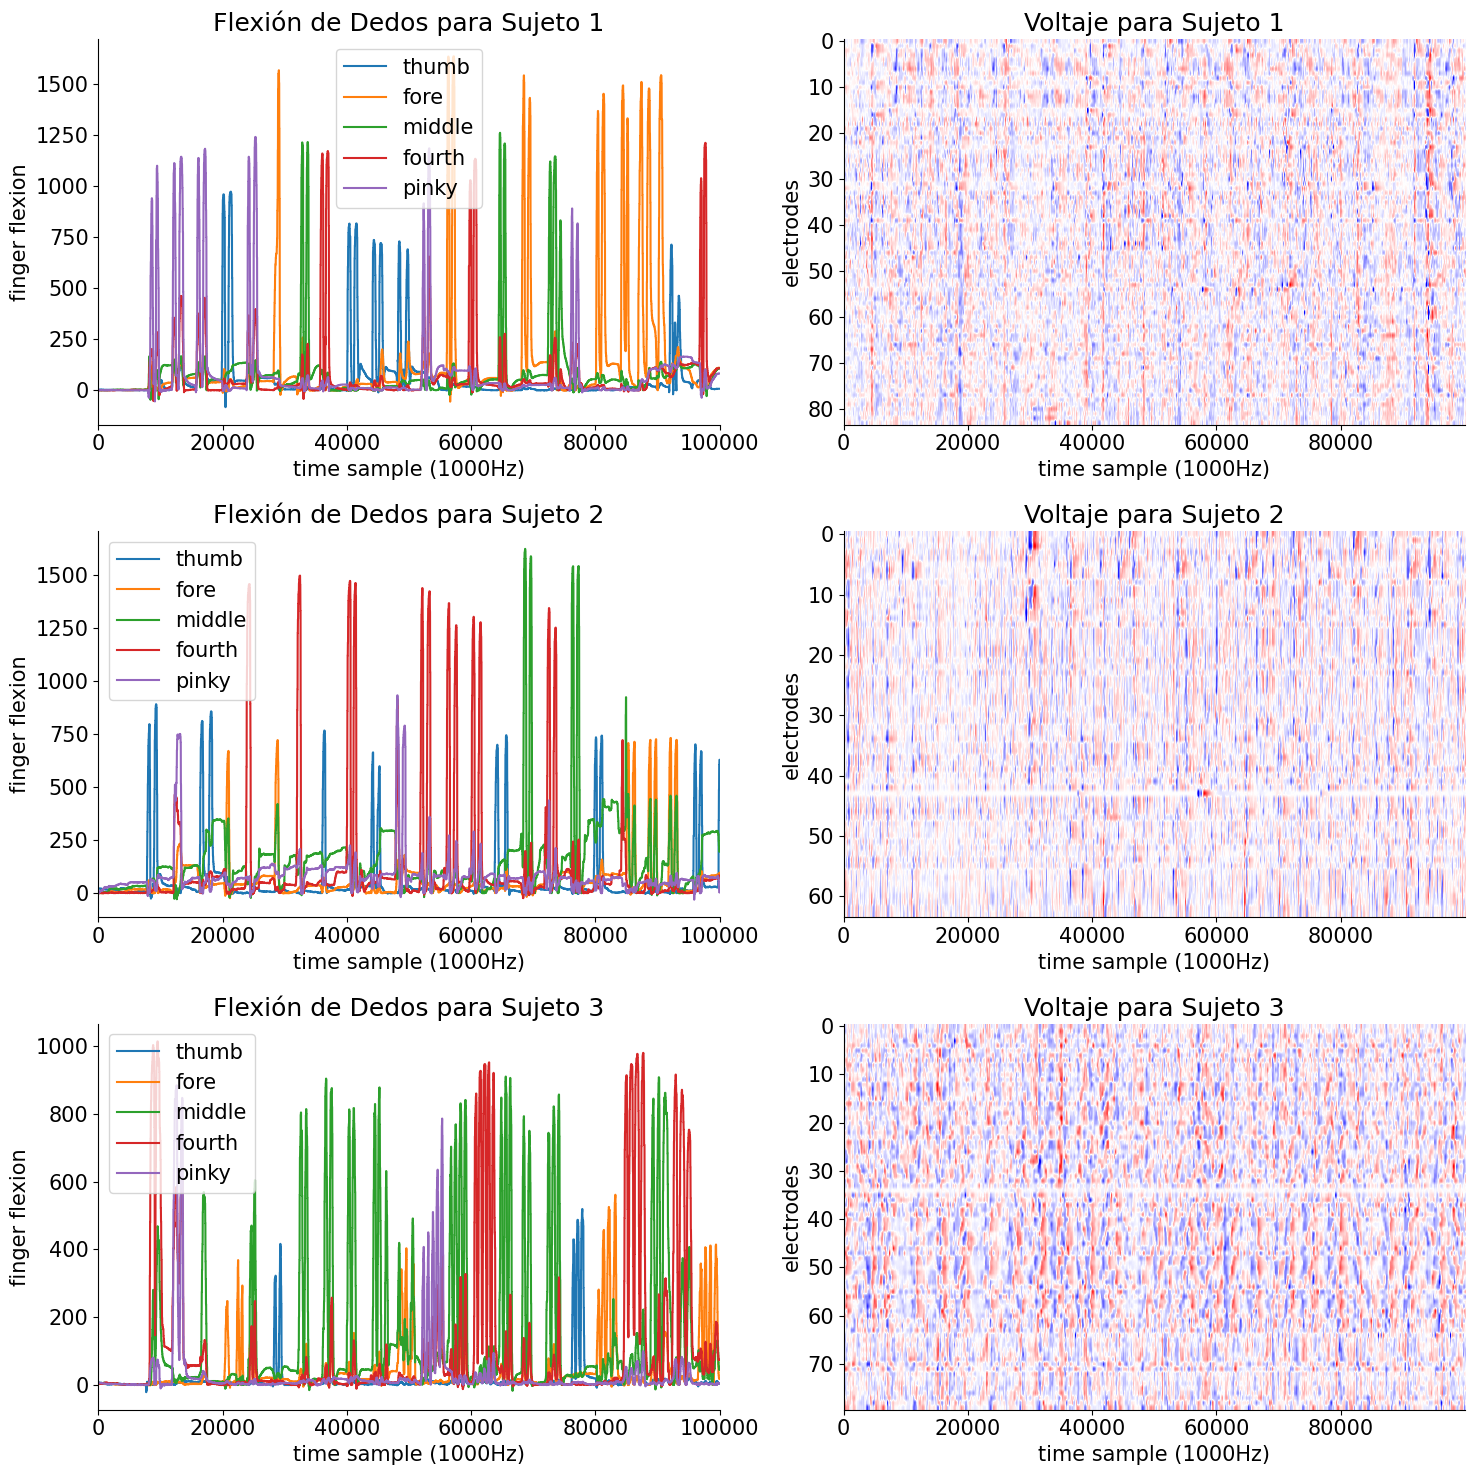

In [15]:
import matplotlib.pyplot as plt
# Crear un grid de 3x3 para las visualizaciones
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Visualizar datos para cada sujeto
for i, dat in enumerate(alldat):
    dg = dat['dg']
    nfingers = dg.shape[1]
    
    # Visualización de la flexión de dedos
    ax = axes[i, 0]
    for j in range(dg.shape[-1]):
        ax.plot(dg[:100000, j])
    
    ax.set_xlabel('time sample (1000Hz)')
    ax.set_ylabel('finger flexion')
    ax.set_xlim([0, 100000])
    ax.legend(dat['stimtext'])
    ax.set_title(f'Flexión de Dedos para Sujeto {i+1}')
    
    # Datos de voltaje en el mismo periodo de tiempo
    V = dat['V'].astype('float32')
    ax = axes[i, 1]
    im = ax.imshow(V[:100000, :].T,
               aspect='auto',
               vmax=4,
               vmin=-4,
               cmap='bwr')
    
    ax.set_xlabel('time sample (1000Hz)')
    ax.set_ylabel('electrodes')
    ax.set_title(f'Voltaje para Sujeto {i+1}')
    
plt.tight_layout()
plt.show()

### Filtrado de Frecuencia

In [24]:
from scipy import signal

# Preprocesamiento de señales para todos los sujetos
for i, dat in enumerate(alldat):
    V = dat['V'].astype('float32')
    
    # Filtro de paso alto para eliminar frecuencias bajas (por debajo de 50 Hz)
    b, a = signal.butter(3, 50, btype='high', fs=1000)
    V = signal.filtfilt(b, a, V, 0)
    
    # Convertir a potencia de señal
    V = np.abs(V)**2
    
    # Filtro de paso bajo para suavizar la señal (por debajo de 3 Hz)
    b, a = signal.butter(3, 3, btype='low', fs=1000)
    V = signal.filtfilt(b, a, V, 0)
    
    # Guardar los datos preprocesados en la estructura original
    dat['V_preprocessed'] = V


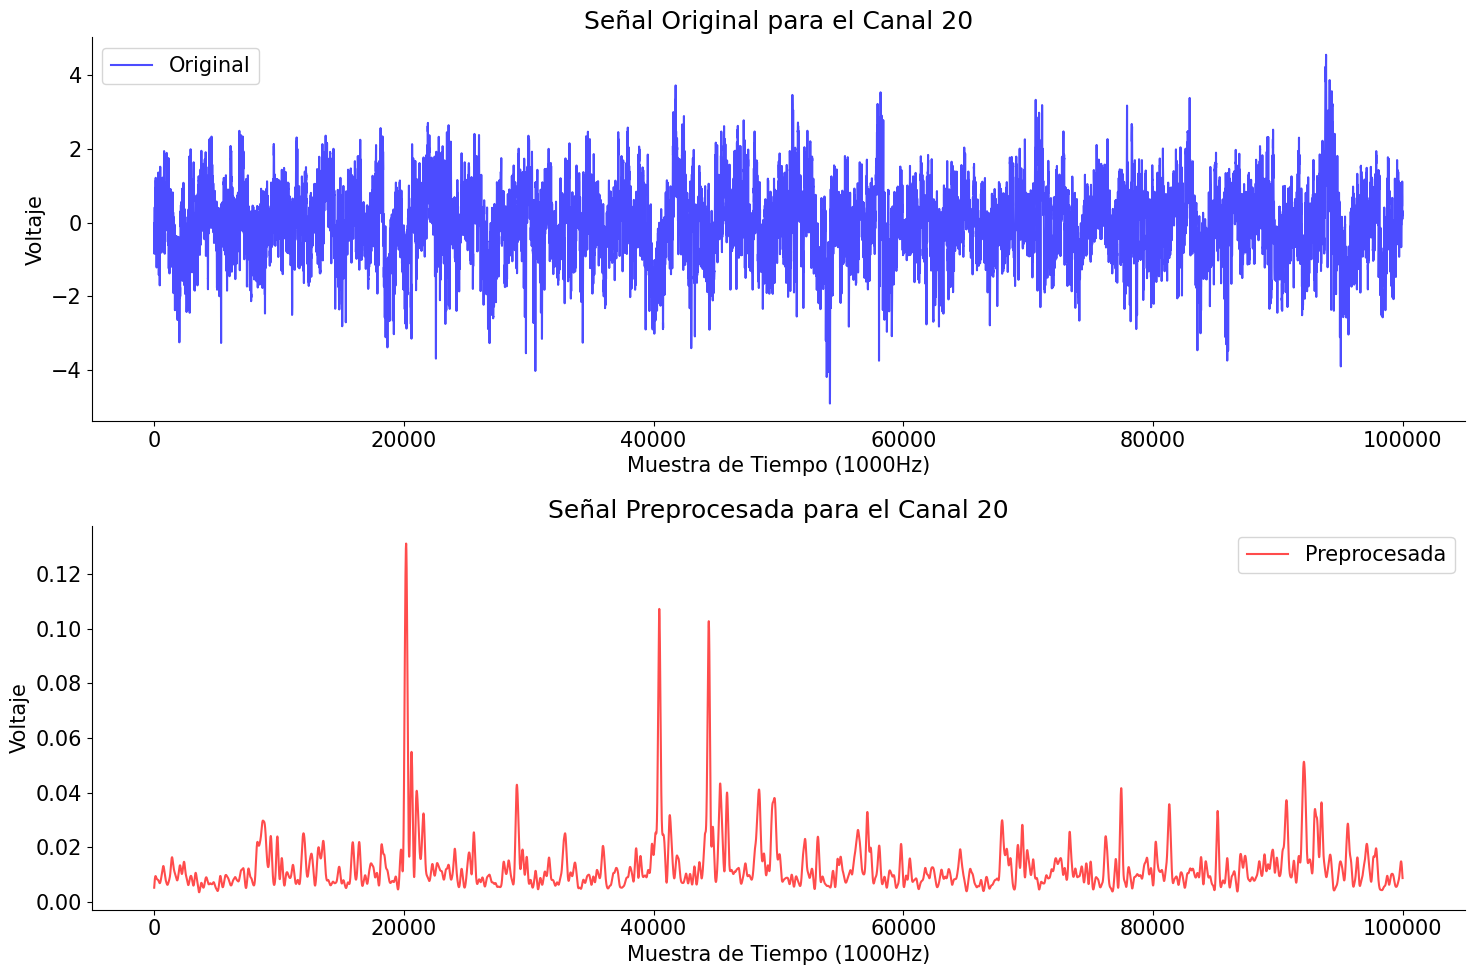

In [23]:
# Seleccionar un canal específico (por ejemplo, el canal 20)
channel = 20
time_samples = 100000  # Número de muestras de tiempo a visualizar

# Crear un grid con 2 filas y 1 columna
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Señal original
axes[0].plot(alldat[0]['V'][:time_samples, channel], label='Original', alpha=0.7, color='blue')
axes[0].set_xlabel('Muestra de Tiempo (1000Hz)')
axes[0].set_ylabel('Voltaje')
axes[0].set_title(f'Señal Original para el Canal {channel}')
axes[0].legend()

# Señal preprocesada
axes[1].plot(alldat[0]['V_preprocessed'][:time_samples, channel], label='Preprocesada', alpha=0.7, color='red')
axes[1].set_xlabel('Muestra de Tiempo (1000Hz)')
axes[1].set_ylabel('Voltaje')
axes[1].set_title(f'Señal Preprocesada para el Canal {channel}')
axes[1].legend()

plt.tight_layout()
plt.show()

### Correlación entre señales preprocesadas

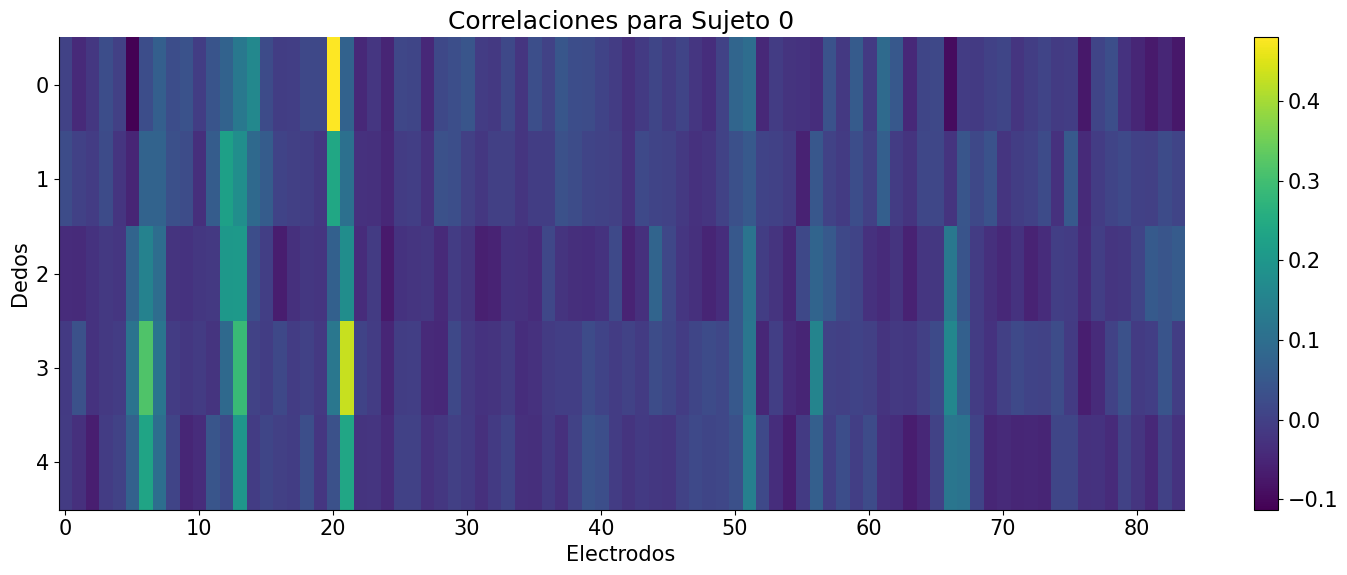

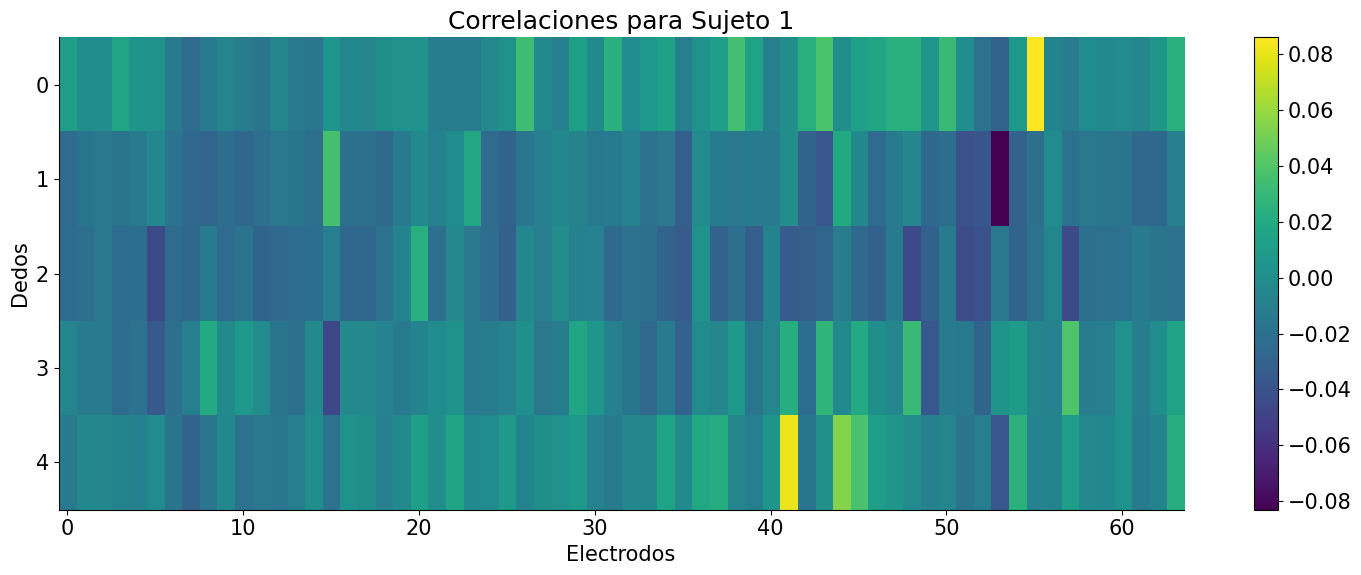

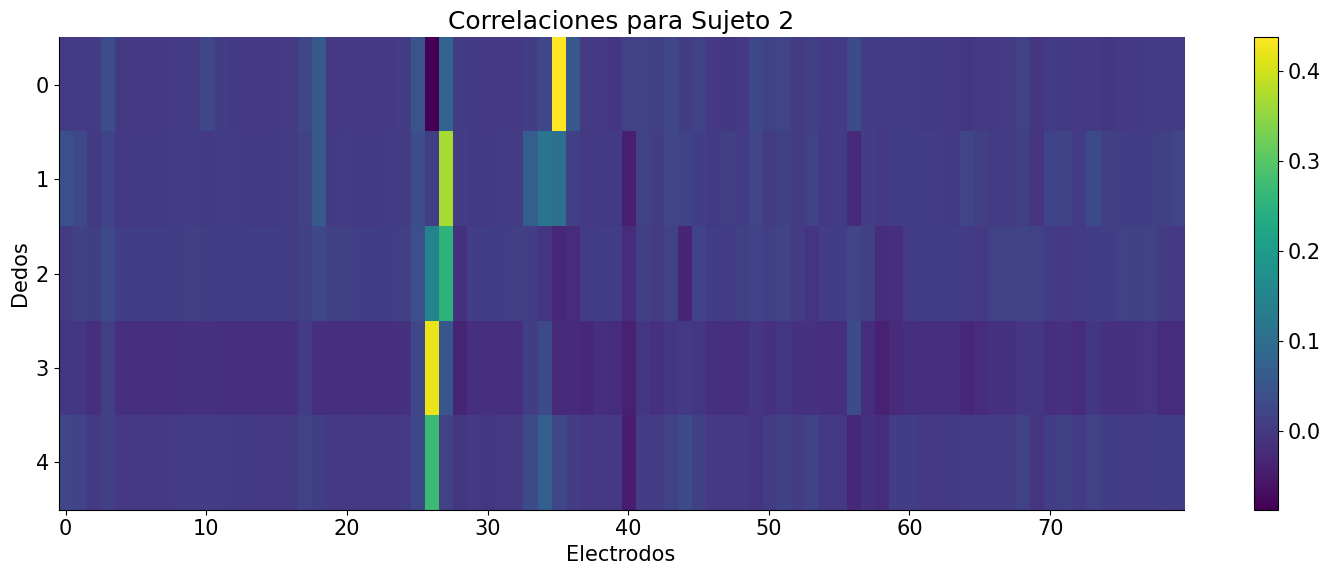

In [26]:
# Preprocesamiento de señales para todos los sujetos
for i, dat in enumerate(alldat):
    V = dat['V_preprocessed']
    dg = dat['dg']
    nfingers = dg.shape[1]
    nt, nchan = V.shape

    cc = np.zeros((nchan, nfingers))
    for j in range(nchan):
        for k in range(nfingers):
            cc[j, k] = np.corrcoef(V[:, j], dg[:, k])[0, 1]

    plt.figure(figsize=(15, 6))
    plt.imshow(cc.T, aspect='auto')
    plt.colorbar()
    plt.xlabel('Electrodos')
    plt.ylabel('Dedos')
    plt.title(f'Correlaciones para Sujeto {i}')
    plt.show()

In [29]:
%%time
### Dynamic Time Warping (DTW)
from dtaidistance import dtw
from scipy.stats import zscore

# Aplicación de DTW para todos los sujetos
for i, dat in enumerate(alldat):
    V = dat['V_preprocessed']
    dg = dat['dg']
    
    # Seleccionar un canal y un dedo para el análisis de ejemplo (canal 20 y dedo 0)
    channel = 20
    finger = 0
    signal1 = zscore(V[:100000, channel])
    signal2 = zscore(dg[:100000, finger])
    
    # Calcular la distancia DTW y la alineación
    distance = dtw.distance(signal1, signal2)
    alignment = dtw.warping_path(signal1, signal2)
    
    # Visualizar alineación
    plt.figure(figsize=(15, 6))
    dtw.plot_warping(signal1, signal2, path=alignment)
    plt.title(f'Alineación DTW para Sujeto {i} (Canal {channel}, Dedo {finger})')
    plt.xlabel('Muestra de Tiempo (1000Hz)')
    plt.ylabel('Señal Normalizada')
    plt.show()
    
    print(f"Distancia DTW para Sujeto {i}: {distance}")